In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU, LayerNormalization, MultiHeadAttention,TimeDistributed, Input, Flatten
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from time import time
import numpy as np
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [3]:

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, Y_train, cv=10, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(init_points=5, n_iter=15)
best_params = optimizer.max['params']

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.6328    | 1.0       | 3.602     | 0.01011   | 5.116     | 232.1     | 1.0       |
| 2         | 0.6273    | 1.0       | 1.728     | 0.4028    | 6.772     | 477.3     | 1.0       |
| 3         | 0.6306    | 1.0       | 4.391     | 0.03711   | 7.693     | 475.6     | 1.0       |
| 4         | 0.5991    | 1.0       | 0.9905    | 0.8027    | 9.778     | 382.1     | 1.0       |
| 5         | 0.6268    | 1.0       | 4.473     | 0.09419   | 3.273     | 252.8     | 1.0       |
| 6         | 0.6268    | 1.0       | 5.0       | 0.01      | 10.0      | 450.7     | 1.0       |
| 7         | 0.6268    | 1.0       | 4.854     | 0.467     | 4.918     | 206.1     | 1.0       |
| 8         | 0.6099    | 1.0       | 0.6525    | 0.314     | 9.943     | 156.5     | 1.0       |
| 9         | 0.6275

In [4]:
model = XGBClassifier(n_estimators=int(best_params['n_estimators']),
                                   gamma=best_params['gamma'],
                                   learning_rate=best_params['learning_rate'],
                                   max_depth=int(best_params['max_depth']),
                                   random_state=42)
model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.263886758294578, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5383830109585772,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=240, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
res = model.predict(X_test)
print(Y_test)

from sklearn.metrics import classification_report
print(classification_report(Y_test,res,digits=6))

      0
2358  1
182   1
33    0
3118  1
499   0
...  ..
1928  1
1399  1
2981  1
817   0
1997  0

[684 rows x 1 columns]
              precision    recall  f1-score   support

           0   0.596491  0.133333  0.217949       255
           1   0.647528  0.946387  0.768939       429

    accuracy                       0.643275       684
   macro avg   0.622010  0.539860  0.493444       684
weighted avg   0.628501  0.643275  0.563526       684



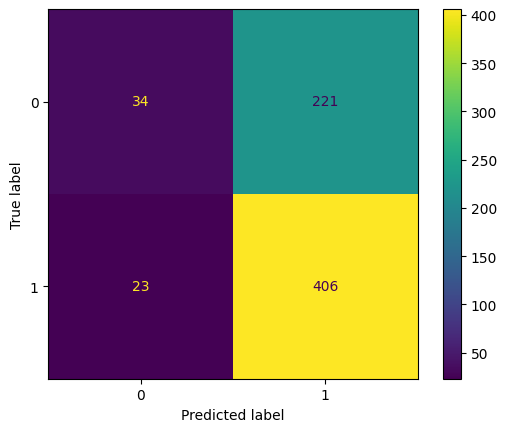

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, res)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()

c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


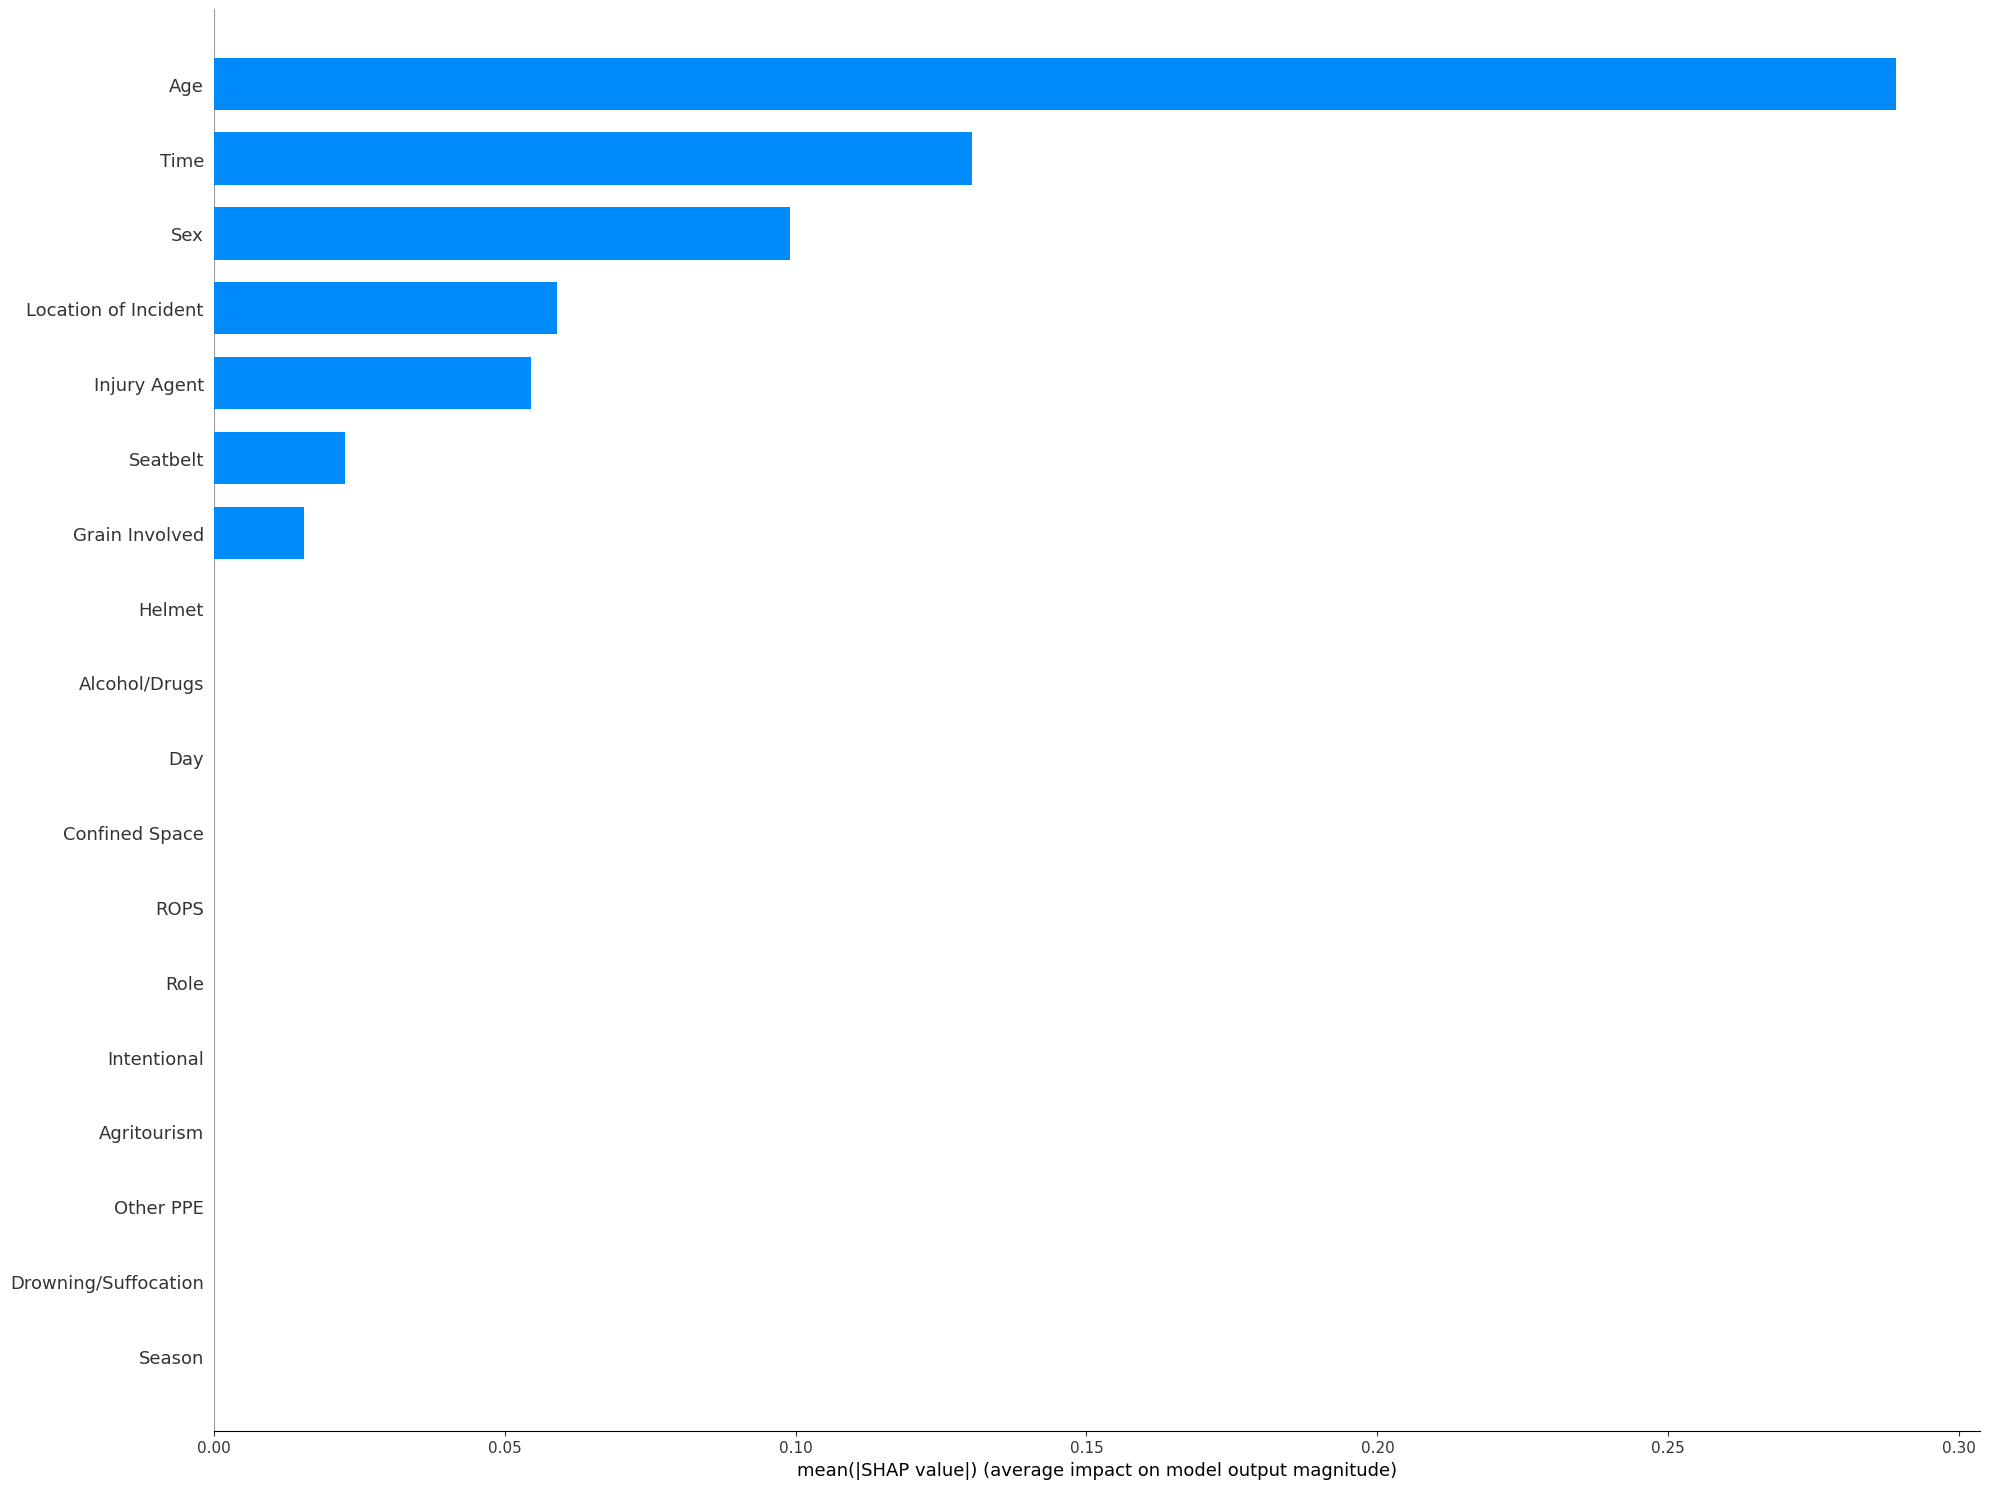

In [7]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names = features,plot_size=(20,15),plot_type="bar",show=False)

c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\plots\_utils.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if color == "shap_red":
c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\plots\_utils.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if color == "shap_blue":
c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\_api\__init__.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if val not in values:


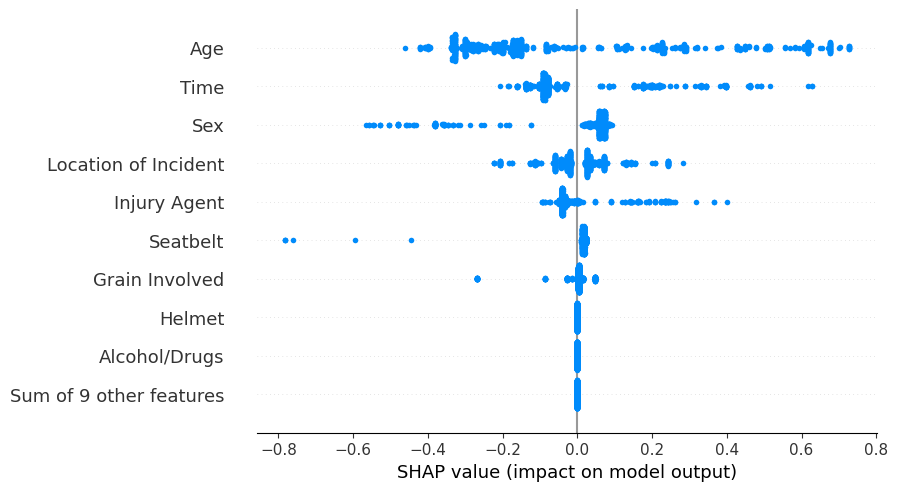

In [8]:
explanation = shap.Explanation(
    values=shap_values, 
    feature_names=features
)
shap.plots.beeswarm(explanation)